# Задание 5.1 - Word2Vec

В этом задании мы натренируем свои word vectors на очень небольшом датасете.
Мы будем использовать самую простую версию word2vec, без negative sampling и других оптимизаций.

Перед запуском нужно запустить скрипт `download_data.sh` чтобы скачать данные.

Датасет и модель очень небольшие, поэтому это задание можно выполнить и без GPU.

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

# We'll use Principal Component Analysis (PCA) to visualize word vectors,
# so make sure you install dependencies from requirements.txt!
from sklearn.decomposition import PCA 

%matplotlib inline

In [0]:
device = torch.device("cuda:0")

In [0]:
import os
import numpy as np

class StanfordTreeBank:
    '''
    Wrapper for accessing Stanford Tree Bank Dataset
    https://nlp.stanford.edu/sentiment/treebank.html
    
    Parses dataset, gives each token and index and provides lookups
    from string token to index and back
    
    Allows to generate random context with sampling strategy described in
    word2vec paper:
    https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf
    '''
    def __init__(self):
        self.index_by_token = {}
        self.token_by_index = []

        self.sentences = []

        self.token_freq = {}
        
        self.token_reject_by_index = None

    def load_dataset(self, folder):
        filename = "/content/drive/My Drive/stanfordSentimentTreebank/datasetSentences.txt"

        with open(filename, "r", encoding="latin1") as f:
            l = f.readline() # skip the first line
            
            for l in f:
                splitted_line = l.strip().split()
                words = [w.lower() for w in splitted_line[1:]] # First one is a number
                    
                self.sentences.append(words)
                for word in words:
                    if word in self.token_freq:
                        self.token_freq[word] +=1 
                    else:
                        index = len(self.token_by_index)
                        self.token_freq[word] = 1
                        self.index_by_token[word] = index
                        self.token_by_index.append(word)
        self.compute_token_prob()
                        
    def compute_token_prob(self):
        words_count = np.array([self.token_freq[token] for token in self.token_by_index])
        words_freq = words_count / np.sum(words_count)
        
        # Following sampling strategy from word2vec paper:
        # https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf
        self.token_reject_by_index = 1- np.sqrt(1e-5/words_freq)
    
    def check_reject(self, word):
        return np.random.rand() > self.token_reject_by_index[self.index_by_token[word]]
        
    def get_random_context(self, context_length=5):
        """
        Returns tuple of center word and list of context words
        """
        sentence_sampled = []
        while len(sentence_sampled) <= 2:
            sentence_index = np.random.randint(len(self.sentences)) 
            sentence = self.sentences[sentence_index]
            sentence_sampled = [word for word in sentence if self.check_reject(word)]
    
        center_word_index = np.random.randint(len(sentence_sampled))
        
        words_before = sentence_sampled[max(center_word_index - context_length//2,0):center_word_index]
        words_after = sentence_sampled[center_word_index+1: center_word_index+1+context_length//2]
        
        return sentence_sampled[center_word_index], words_before+words_after
    
    def num_tokens(self):
        return len(self.token_by_index)
        
data = StanfordTreeBank()
data.load_dataset("./stanfordSentimentTreebank/")

print("Num tokens:", data.num_tokens())
for i in range(5):
    center_word, other_words = data.get_random_context(5)
    print(center_word, other_words)

Num tokens: 19538
cinematic ['history', 'releasing', 'flotsam', 'occasion']
separate ['divide', 'two', 'groups', 'reaching']
because ['profiles', 'homes', 'owners', 'fully']
newfoundland ['captures', 'prevalent']
; ['move', 'sequel']


# Имплеменируем PyTorch-style Dataset для Word2Vec

Этот Dataset должен сгенерировать много случайных контекстов и превратить их в сэмплы для тренировки.

Напоминаем, что word2vec модель получает на вход One-hot вектор слова и тренирует простую сеть для предсказания на его основе соседних слов.
Из набора слово-контекст создается N сэмплов (где N - количество слов в контексте):

Например:

Слово: `orders` и контекст: `['love', 'nicest', 'to', '50-year']` создадут 4 сэмпла:
- input: `orders`, target: `love`
- input: `orders`, target: `nicest`
- input: `orders`, target: `to`
- input: `orders`, target: `50-year`

Все слова на входе и на выходе закодированы через one-hot encoding, с размером вектора равным количеству токенов.

In [0]:
class Word2VecPlain(Dataset):
    '''
    PyTorch Dataset for plain Word2Vec.
    Accepts StanfordTreebank as data and is able to generate dataset based on
    a number of random contexts
    '''
    def __init__(self, data, num_contexts=30000):
        '''
        Initializes Word2VecPlain, but doesn't generate the samples yet
        (for that, use generate_dataset)
        Arguments:
        data - StanfordTreebank instace
        num_contexts - number of random contexts to use when generating a dataset
        '''
        self.data = data
        self.num_contexts = num_contexts
        
        self.input_data = None
        self.output_data = None
        self.num_tokens = self.data.num_tokens()
        
        # TODO: Implement what you need for other methods!
    
    def generate_dataset(self):
        '''
        Generates dataset samples from random contexts
        Note: there will be more samples than contexts because every context
        can generate more than one sample
        '''
        # TODO: Implement generating the dataset
        # You should sample num_contexts contexts from the data and turn them into samples
        # Note you will have several samples from one context
        
        a = []
        b = []
        for i in range(self.num_contexts):
            central_word, other_words = self.data.get_random_context()
            for el in other_words:
                a.append(self.data.index_by_token[central_word])
                b.append(self.data.index_by_token[el])
                
        x = torch.zeros(len(a), len(self.data.index_by_token))
        y = torch.zeros(len(b), len(self.data.index_by_token))
        
        x[range(x.shape[0]), a]=1
        y[range(y.shape[0]), b]=1
        
        self.output_data = y
        self.input_data = x
            
            
        
    def __len__(self):
        '''
        Returns total number of samples
        '''
        # TODO: Return the number of samples
        return self.input_data.shape[0]
    
    def __getitem__(self, index):
        '''
        Returns i-th sample
        
        Return values:
        input_vector - torch.Tensor with one-hot representation of the input vector
        output_index - index of the target word (not torch.Tensor!)
        '''
        # TODO: Generate tuple of 2 return arguments for i-th sample  
        return self.input_data[index, :], torch.argmax(self.output_data[index, :], dim=-1)


In [0]:
dataset = Word2VecPlain(data, 10)
dataset.generate_dataset()
input_vector, target = dataset[0]
print("Sample - input: %s, target: %s" % (input_vector, int(target))) # target should be able to convert to int
assert isinstance(input_vector, torch.Tensor)
assert torch.sum(input_vector) == 1.0
assert input_vector.shape[0] == data.num_tokens()

Sample - input: tensor([0., 0., 0.,  ..., 0., 0., 0.]), target: 14788


# Создаем модель и тренируем ее

In [0]:
# Create the usual PyTorch structures
dataset = Word2VecPlain(data, 20000)
dataset.generate_dataset()
a = dataset.num_tokens
print(len(dataset))
# We'll be training very small word vectors!
wordvec_dim = 300

# We can use a standard sequential model for this
nn_model = nn.Sequential(
            nn.Linear(a, wordvec_dim, bias=True),
            nn.Linear(wordvec_dim, a, bias=True), 
         )
nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

55184


Sequential(
  (0): Linear(in_features=19538, out_features=300, bias=True)
  (1): Linear(in_features=300, out_features=19538, bias=True)
)

In [0]:
def extract_word_vectors(nn_model):
    '''
    Extracts word vectors from the model
    
    Returns:
    input_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    output_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    '''
    # TODO: Implement extracting word vectors from param weights
    # return tuple of input vectors and output vectos 
    # Hint: you can access weights as Tensors through nn.Linear class attributes
    
    w1, b1, w2, b2 = nn_model.parameters()
    return w1.T, w2

untrained_input_vectors, untrained_output_vectors = extract_word_vectors(nn_model)
assert untrained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert untrained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

In [0]:
def train_model(model, dataset, train_loader, optimizer, loss, scheduler, num_epochs):
    '''
    Trains plain word2vec using cross-entropy loss and regenerating dataset every epoch
    
    Returns:
    loss_history, train_history
    '''
    
    loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
    
    loss_history = []
    train_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        
        for i_step, (x, y) in enumerate(train_loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu) 
            # print(prediction.shape)   
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
        
        
        ave_loss = loss_accum / i_step
        loss_history.append(ave_loss)
        train_accuracy = float(correct_samples) / total_samples    
        train_history.append(train_accuracy) 
        
        dataset.generate_dataset() # Regenerate dataset every epoch
        
        # TODO Implement training for this model
        # Note we don't have any validation set here because our purpose is the word vectors,
        # not the predictive performance of the model
        #
        # And don't forget to step the learing rate scheduler!  
        print("Epoch %i, Average loss: %f, Train accuracy: %f" % (epoch, ave_loss, train_accuracy))
        
    return loss_history, train_history

# Ну и наконец тренировка!

Добейтесь значения ошибки меньше **8.0**.

In [0]:
# Finally, let's train the model!

# TODO: We use placeholder values for hyperparameters - you will need to find better values!
optimizer = optim.Adam(nn_model.parameters(), lr=1e-2, weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=256)
loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)

loss_history, train_history = train_model(nn_model, dataset, train_loader, optimizer, loss, scheduler, 100)

Epoch 0, Average loss: 8.210674, Train accuracy: 0.138623
Epoch 1, Average loss: 11.236333, Train accuracy: 0.055780
Epoch 2, Average loss: 10.387861, Train accuracy: 0.063355
Epoch 3, Average loss: 10.174833, Train accuracy: 0.067602
Epoch 4, Average loss: 10.075673, Train accuracy: 0.068986
Epoch 5, Average loss: 9.901899, Train accuracy: 0.070697
Epoch 6, Average loss: 9.812751, Train accuracy: 0.068442
Epoch 7, Average loss: 9.727770, Train accuracy: 0.067706
Epoch 8, Average loss: 9.580518, Train accuracy: 0.070375
Epoch 9, Average loss: 9.520097, Train accuracy: 0.070423
Epoch 10, Average loss: 9.467127, Train accuracy: 0.068764
Epoch 11, Average loss: 9.388891, Train accuracy: 0.069096
Epoch 12, Average loss: 9.286204, Train accuracy: 0.067531
Epoch 13, Average loss: 9.204078, Train accuracy: 0.069532
Epoch 14, Average loss: 9.137729, Train accuracy: 0.070321
Epoch 15, Average loss: 9.118824, Train accuracy: 0.068075
Epoch 16, Average loss: 9.056088, Train accuracy: 0.069320
Epo

KeyboardInterrupt: ignored

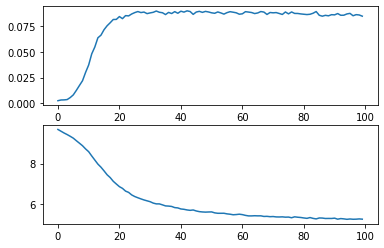

In [0]:
# Visualize training graphs
plt.subplot(211)
plt.plot(train_history)
plt.subplot(212)
plt.plot(loss_history)

# Визуализируем вектора для разного вида слов до и после тренировки

В случае успешной тренировки вы должны увидеть как вектора слов разных типов (например, знаков препинания, предлогов и остальных) разделяются семантически.

Студенты - в качестве выполненного задания присылайте notebook с диаграммами!

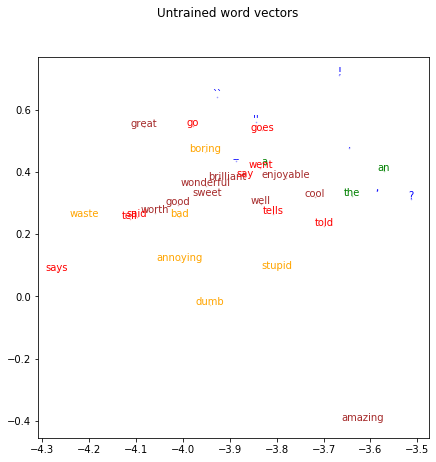

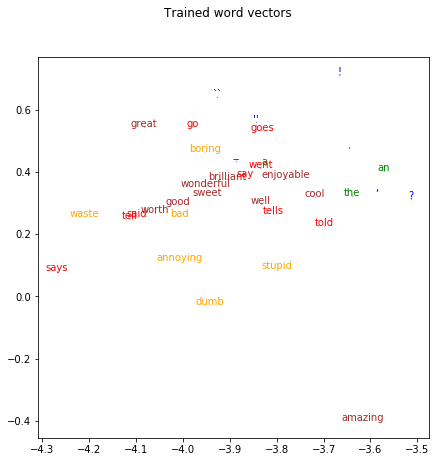

In [0]:
trained_input_vectors, trained_output_vectors = extract_word_vectors(nn_model)
assert trained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert trained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

def visualize_vectors(input_vectors, output_vectors, title=''):
    full_vectors = torch.cat((input_vectors, output_vectors), 0).cpu().detach()
    wordvec_embedding = PCA(n_components=2).fit_transform(full_vectors)

    # Helpful words form CS244D example
    # http://cs224d.stanford.edu/assignment1/index.html
    visualize_words = {'green': ["the", "a", "an"], 
                      'blue': [",", ".", "?", "!", "``", "''", "--"], 
                      'brown': ["good", "great", "cool", "brilliant", "wonderful", 
                              "well", "amazing", "worth", "sweet", "enjoyable"],
                      'orange': ["boring", "bad", "waste", "dumb", "annoying", "stupid"],
                      'red': ['tell', 'told', 'said', 'say', 'says', 'tells', 'goes', 'go', 'went']
                     }

    plt.figure(figsize=(7,7))
    plt.suptitle(title)
    for color, words in visualize_words.items():
        points = np.array([wordvec_embedding[data.index_by_token[w]] for w in words])
        for i, word in enumerate(words):
            plt.text(points[i, 0], points[i, 1], word, color=color,horizontalalignment='center')
        plt.scatter(points[:, 0], points[:, 1], c=color, alpha=0.3, s=0.5)

visualize_vectors(untrained_input_vectors, untrained_output_vectors, "Untrained word vectors")
visualize_vectors(trained_input_vectors, trained_output_vectors, "Trained word vectors")